### Deep Learning - Assignment 3 - CH22M503

#### Author - Aloy Banerjee
###### Roll No. CH22M503

##  Multilayer Perceptrons in PyTorch and Sklearn
#### 1. This entire assignment must be completed in a jupyter notebook. Specifically, use Google Colab to do all your coding and then download the resultant notebook (with the outputs still in the cells) as an ipynb file and submit the same. Using Google Colab is recommended as it will ensure some level of uniformity in hardware and therefore ease the evaluation process.
#### 2. We will be using sklearn and PyTorch for our neural networks. Using Tensorflow for neural networks is not allowed for this assignment.
#### 3. For uniformity, please use this piece of code as the first cell of your notebook and make sure you run this cell before   any other cells are run (If this cell is not present in your submission, you will be awarded 0 marks):
#### def seed_everything(seed=42):
####     random.seed(seed)
####     os.environ['PYTHONHASHSEED']=str(seed)
####     np.random.seed(seed)
####     torch.manual_seed(seed)
####     torch.use_deterministic_algorithms(True)
#### seed_everything(seed=42)
#### 4. In this assignment our goal is to code a multi layer perceptron including backpropagation and gradient descent using Pytorch. Since Pytorch takes care of backpropagation and gradient descent, we are primarily concerned with the code for forward pass and model building. We will not be using any Pytorch DataLoaders in this exercise.
#### 5. The dataset to be used is the MNIST dataset. The dataset can be loaded with the following code:
#### from tensorflow.keras.datasets import mnist
#### (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#### 6. Please split the X_train and Y_train data further using sklearn’s train_test_split function with random_state as 42 and test_size as 0.20 to get the new X_train and Y_train and also X_val and Y_val.
#### 7. Using matplotlib.pyplot.imshow, display the first image in the X_train numpy array and the corresponding label from the Y_train numpy array (This label should be printed in the next cell). Set the cmap parameter of this imshow function as "gray".
#### 8. The network architecture is as follows:
##### a. A Linear Layer with number of input features as 784 and number of output features as 16
##### b. A Non Linear Activation of ReLU
##### c. A Linear Layer with number of input features as 16 and number of output features as 32
##### d. A Non Linear Activation of ReLU
##### e. A Linear Layer with number of input features as 32 and number of output features as 16
##### f. A Non Linear Activation of LeakyReLU
##### g. A Linear Layer with number of input features as 16 and number of output features as 10
##### h. An appropriate layer that finally gives us probabilities of the different classes. Choose this layer yourself. There is only one correct answer.

#### 9. Make sure that you make a python class for the PyTorch model.
#### 10. The optimizer for this exercise will be the Adam Optimizer. Keep the learning rate of the optimizer as 1e-2.
#### 11. The loss function for this will be the CrossEntropyLoss already implemented in PyTorch. You should not write your own Cross Entropy Loss module.
#### 12. Make a separate python class that will be used for training this model.Train this model for such that it sees each data point exactly 1000 times. Make sure you print the training loss every 50th time the full dataset is seen. If the the prints of your loss are not present, marks will be deducted.
#### 13. Post training this model, use it to make predictions on all the three different sets of data we have which are the training set (𝑋_𝑡𝑟𝑎𝑖𝑛,𝑌_𝑡𝑟𝑎𝑖𝑛), validation set (𝑋_𝑣𝑎𝑙,𝑌_𝑣𝑎𝑙), testing set (𝑋_𝑡𝑒𝑠𝑡,𝑌_𝑡𝑒𝑠𝑡).
#### 14. Based on the predictions, find the precision, recall and f1 score for all the different classes (which are the digits). Also report the accuracies for each class and report a weighted average accuracy across all classes. Using any sklearn functions for this task is not allowed.
#### 15. Now, we will do the same exercise with sklearn. Use the MLPClassifier class from sklearn. Using this class, keep the architecture of the hidden layers as the same as previously mentioned in point 8. Sklearn automatically adjusts and recognises the input sizes for the input and output layer of the neural network. Use relu as the activation for all layers and use the random_state value as 42. Do not change any other parameters of the class.
#### 16. Fit the class to the X_train and Y_train data.
#### 17. Use the fitted class to make predictions on the three datasets mentioned in point 13.
#### 18. Create classification reports using sklearn.metrics.classification_report for the different sets of predictions.

#### Reference

In [1]:
# https://github.com/fadilparves/pytorch-ann/blob/main/main.py

#### Importing Library

In [2]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Define the constant value

In [3]:
epochs = 1000
seed = 42
round_precesion = 2

#### Common Method

In [4]:
def seed_everything(seed=seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    
def data_load():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

def normalize_data(X):
    return X.astype('float32') / 255.

def one_hot_encode_labels(Y):
    return np.eye(10)[Y]

def flatten_array(X):
    return X.reshape((len(X), np.prod(X.shape[1:])))

def data_normalize(X_train, X_validation, X_test, Y_train, Y_validation, Y_test):
    # Normalize the input images
    X_train = normalize_data(X_train)
    X_validation = normalize_data(X_validation)
    X_test = normalize_data(X_test)
    # Convert the labels to one-hot encoding
    Y_train = one_hot_encode_labels(Y_train)
    Y_validation = one_hot_encode_labels(Y_validation)
    Y_test = one_hot_encode_labels(Y_test)
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

def flatten_data(X_train,X_val,X_test):
    X_train = flatten_array(X_train)
    X_val = flatten_array(X_val)
    X_test = flatten_array(X_test)
    return X_train, X_val, X_test    

def get_classification_metrics(actual_labels, predicted_labels):
    unique_labels = np.sort(np.unique(actual_labels))
    actual_labels_np = actual_labels.numpy()
    predicted_labels_np = predicted_labels.numpy()
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))
    classification_report = np.zeros((len(unique_labels), 5))    
    # Calculate confusion matrix
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            confusion_matrix[i, j] = np.sum((actual_labels_np == unique_labels[i]) & (predicted_labels_np == unique_labels[j]))            
    # Calculate category accuracy
    category_accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)    
    weighted_acc = 0
    # Calculate metrics for each category
    for j in range(len(unique_labels)):        
        actual_label, predicted_label = (actual_labels_np == unique_labels[j]), (predicted_labels_np == unique_labels[j])
        true_positives, false_positives, false_negatives = np.sum(actual_label & predicted_label), np.sum(~actual_label & predicted_label), np.sum(actual_label & ~predicted_label)
        count = np.sum(actual_labels_np == unique_labels[j])
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall) 
        classification_report[j, :] = np.round([precision, recall, f1_score, category_accuracy[j], count], round_precesion)
        weighted_acc += (f1_score * count)        
    weighted_acc = weighted_acc / len(actual_labels)    
    return weighted_acc, classification_report

#### Seed everything 

In [5]:
seed_everything(seed=seed)

#### 6. Please split the X_train and Y_train data further using sklearn’s train_test_split function with random_state as 42 and test_size as 0.20 to get the new X_train and Y_train and also X_val and Y_val

#### Train test and validation data split 

In [6]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = data_load()

11490434/11490434 [==============================] - 1s 0us/step


#### Verify the dimention of the data

In [7]:
print(f'X_train Shape : {X_train.shape}')
print(f'X_val Shape : {X_val.shape}')
print(f'X_test Shape : {X_test.shape}')
print(f'Y_train Shape : {Y_train.shape}')
print(f'Y_val Shape : {Y_val.shape}')
print(f'Y_test Shape : {Y_test.shape}')

X_train Shape : (48000, 28, 28)
X_val Shape : (12000, 28, 28)
X_test Shape : (10000, 28, 28)
Y_train Shape : (48000,)
Y_val Shape : (12000,)
Y_test Shape : (10000,)


#### 7. Using matplotlib.pyplot.imshow, display the first image in the X_train numpy array and the corresponding label from the Y_train numpy array (This label should be printed in the next cell). Set the cmap parameter of this imshow function as "gray".

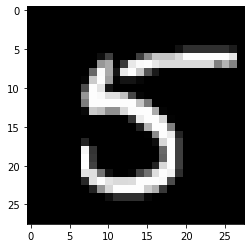

In [8]:
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [9]:
print("Label: ", Y_train[0])

Label:  5


#### 8. The network architecture is as follows:
##### a. A Linear Layer with number of input features as 784 and number of output features as 16
##### b. A Non Linear Activation of ReLU
##### c. A Linear Layer with number of input features as 16 and number of output features as 32
##### d. A Non Linear Activation of ReLU
##### e. A Linear Layer with number of input features as 32 and number of output features as 16
##### f. A Non Linear Activation of LeakyReLU
##### g. A Linear Layer with number of input features as 16 and number of output features as 10
##### h. An appropriate layer that finally gives us probabilities of the different classes. Choose this layer yourself. There is only one correct answer.

In [10]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(in_features = 784, out_features = 16)        
        self.linear2 = nn.Linear(in_features = 16, out_features = 32)        
        self.linear3 = nn.Linear(in_features = 32, out_features = 16)        
        self.linear4 = nn.Linear(in_features = 16, out_features = 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        #Commented out because CrossEntropyLoss criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
        #https://discuss.pytorch.org/t/need-help-pytorch-softmax-cross-entropy-loss-function/146243 
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.leakyrelu(out)
        out = self.linear4(out)
        #Commented out because CrossEntropyLoss criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
        #https://discuss.pytorch.org/t/need-help-pytorch-softmax-cross-entropy-loss-function/146243 
        #out = self.softmax(out)
        return out

#### Normalize and flatten the data set before feed into neural network

In [11]:
# Normalize the images and one hot encoded
X_train, X_val, X_test, Y_train, Y_val, Y_test = data_normalize(X_train, X_val, X_test, Y_train, Y_val, Y_test)
# Flatten the images
X_train,X_val,X_test = flatten_data(X_train,X_val,X_test)

In [12]:
print(f'X_train Shape : {X_train.shape}')
print(f'X_validation Shape : {X_val.shape}')
print(f'X_test Shape : {X_test.shape}')

X_train Shape : (48000, 784)
X_validation Shape : (12000, 784)
X_test Shape : (10000, 784)


#### 10. The optimizer for this exercise will be the Adam Optimizer. Keep the learning rate of the optimizer as 1e-2.
#### 11. The loss function for this will be the CrossEntropyLoss already implemented in PyTorch. You should not write your own Cross Entropy Loss module.
#### 12. Make a separate python class that will be used for training this model.Train this model for such that it sees each data point exactly 1000 times. Make sure you print the training loss every 50th time the full dataset is seen. If the the prints of your loss are not present, marks will be deducted.

#####     Accuracy = Correct Predictions / Total Cases * 100%
#####     Precision = TP / (TP + FP) * 100%
#####     Recall = TP / TP + FN.
#####     F1 Score = 2 * Precision * Recall / Precision + Recall.

In [13]:
class Trainer:
    
    def __init__(self, model, train_data, val_data, test_data):
        self.model = model
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-2)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, epochs):
        running_loss = 0.0  
        for epoch in range(epochs):            
            data = self.train_data
            inputs, labels = torch.tensor(data[0]),torch.tensor(data[1])
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
            if epoch % 50 == 49:
                print(f"Epoch : {epoch+1}, Average Loss : {np.round(running_loss/len(self.train_data),round_precesion)}, Training Loss : {np.round(loss.item(),round_precesion)}, Running Loss : {np.round(running_loss,round_precesion)}")
                print('==================================================================================')

    def test(self, data):
        with torch.no_grad():
            inputs, labels = torch.tensor(data[0]),data[1]
            outputs = self.model(inputs)           
            _, predicted = torch.max(outputs.data, 1)            
            labels = torch.tensor(labels)
            labels_recons = np.argmax(labels, axis=1)
            weighted_acc, report = get_classification_metrics(labels_recons, predicted)
            #print('Weighted Accuracy: ', weighted_acc, '\nReport: ', report)
            return predicted, weighted_acc, report
        

#### 13. Post training this model, use it to make predictions on all the three different sets of data we have which are the training set (𝑋_𝑡𝑟𝑎𝑖𝑛,𝑌_𝑡𝑟𝑎𝑖𝑛), validation set (𝑋_𝑣𝑎𝑙,𝑌_𝑣𝑎𝑙), testing set (𝑋_𝑡𝑒𝑠𝑡,𝑌_𝑡𝑒𝑠𝑡).
#### 14. Based on the predictions, find the precision, recall and f1 score for all the different classes (which are the digits).Also report the accuracies for each class and report a weighted average accuracy across all classes. Using anysklearn functions for this task is not allowed.

In [14]:
model = MLP()
trainer = Trainer(model, [X_train,Y_train], [X_val,Y_val], [X_test,Y_test])
trainer.train(epochs)   

Epoch : 50, Average Loss : 24.56, Training Loss : 0.34, Running Loss : 49.13
Epoch : 100, Average Loss : 30.81, Training Loss : 0.2, Running Loss : 61.61
Epoch : 150, Average Loss : 35.14, Training Loss : 0.15, Running Loss : 70.27
Epoch : 200, Average Loss : 38.54, Training Loss : 0.12, Running Loss : 77.08
Epoch : 250, Average Loss : 41.32, Training Loss : 0.1, Running Loss : 82.64
Epoch : 300, Average Loss : 43.61, Training Loss : 0.08, Running Loss : 87.22
Epoch : 350, Average Loss : 45.58, Training Loss : 0.07, Running Loss : 91.16
Epoch : 400, Average Loss : 47.43, Training Loss : 0.11, Running Loss : 94.86
Epoch : 450, Average Loss : 49.15, Training Loss : 0.06, Running Loss : 98.3
Epoch : 500, Average Loss : 50.48, Training Loss : 0.05, Running Loss : 100.97
Epoch : 550, Average Loss : 51.72, Training Loss : 0.05, Running Loss : 103.44
Epoch : 600, Average Loss : 53.74, Training Loss : 0.12, Running Loss : 107.47
Epoch : 650, Average Loss : 55.75, Training Loss : 0.05, Running 

In [15]:
#Train
train_predicted, train_weighted_acc, train_report = trainer.test([X_train,Y_train])
#Validation
val_predicted, val_weighted_acc, val_report = trainer.test([X_val,Y_val])
#Test
test_predicted, test_weighted_acc, test_report = trainer.test([X_test,Y_test])

In [16]:
df_result_train = pd.DataFrame(train_report, columns = ['Precision','Recall','F1 - Score', 'Accuracy - Category wise', 'Count - Category wise'])
df_result_validation = pd.DataFrame(val_report, columns = ['Precision','Recall','F1 - Score', 'Accuracy - Category wise', 'Count - Category wise'])
df_result_test = pd.DataFrame(test_report, columns = ['Precision','Recall','F1 - Score', 'Accuracy - Category wise', 'Count - Category wise'])

In [17]:
print('Training Set - Report')
print(f'Train Weighted Accuracy {train_weighted_acc}')
display(df_result_train)
print('Validation Set - Report')
print(f'Validation Weighted Accuracy {val_weighted_acc}')
display(df_result_validation)
print('Test Set - Report')
print(f'Test Weighted Accuracy {test_weighted_acc}')
display(df_result_test)

Training Set - Report
Train Weighted Accuracy 0.9559300088197356


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,0.97,0.98,0.98,0.98,4748.0
1,0.98,0.98,0.98,0.98,5420.0
2,0.97,0.95,0.96,0.95,4784.0
3,0.94,0.94,0.94,0.94,4912.0
4,0.95,0.96,0.95,0.96,4666.0
5,0.95,0.93,0.94,0.93,4317.0
6,0.97,0.98,0.97,0.98,4741.0
7,0.97,0.96,0.97,0.96,4966.0
8,0.93,0.94,0.93,0.94,4691.0
9,0.93,0.94,0.94,0.94,4755.0


Validation Set - Report
Validation Weighted Accuracy 0.9401417327679762


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,0.96,0.97,0.96,0.97,1175.0
1,0.97,0.97,0.97,0.97,1322.0
2,0.94,0.93,0.93,0.93,1174.0
3,0.94,0.91,0.92,0.91,1219.0
4,0.94,0.95,0.94,0.95,1176.0
5,0.91,0.91,0.91,0.91,1104.0
6,0.96,0.97,0.97,0.97,1177.0
7,0.95,0.94,0.95,0.94,1299.0
8,0.91,0.93,0.92,0.93,1160.0
9,0.91,0.92,0.91,0.92,1194.0


Test Set - Report
Test Weighted Accuracy 0.939757711386582


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,0.95,0.97,0.96,0.97,980.0
1,0.97,0.98,0.98,0.98,1135.0
2,0.94,0.94,0.94,0.94,1032.0
3,0.91,0.93,0.92,0.93,1010.0
4,0.94,0.96,0.95,0.96,982.0
5,0.91,0.90,0.91,0.90,892.0
6,0.95,0.95,0.95,0.95,958.0
7,0.96,0.93,0.95,0.93,1028.0
8,0.92,0.92,0.92,0.92,974.0
9,0.94,0.91,0.93,0.91,1009.0



15. Now, we will do the same exercise with sklearn. Use the MLPClassifier class from sklearn. Using this class, keep
the architecture of the hidden layers as the same as previously mentioned in point 8. Sklearn automatically adjusts
and recognises the input sizes for the input and output layer of the neural network. Use relu as the activation for all
layers and use the random_state value as 42. Do not change any other parameters of the class

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(16,32,16,10), activation='relu', random_state=seed)

16. Fit the class to the X_train and Y_train data.


In [19]:
mlp.fit(X_train, Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(16, 32, 16, 10), random_state=42)

17. Use the fitted class to make predictions on the three datasets mentioned in point 13.


In [20]:
y_train_prediction = mlp.predict(X_train)
y_val_prediction = mlp.predict(X_val)
y_test_prediction = mlp.predict(X_test)

18. Create classification reports using sklearn.metrics.classification_report for the different sets of predictions.


In [21]:
print('Train')
print(classification_report(Y_train, y_train_prediction, digits=round_precesion))
print('\n\nValdiation')
print(classification_report(Y_val, y_val_prediction, digits=round_precesion))
print('\n\nTest')
print(classification_report(Y_test, y_test_prediction, digits=round_precesion))

Train
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4748
           1       0.99      1.00      1.00      5420
           2       0.99      0.99      0.99      4784
           3       0.99      0.99      0.99      4912
           4       1.00      1.00      1.00      4666
           5       1.00      0.99      0.99      4317
           6       0.99      1.00      0.99      4741
           7       1.00      1.00      1.00      4966
           8       1.00      0.99      1.00      4691
           9       1.00      0.99      1.00      4755

   micro avg       1.00      1.00      1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000
 samples avg       0.99      1.00      0.99     48000



Valdiation
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1175
           1       0.97      0.98      0.98      1322
     

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looking at the results of MLP classifier and our own pytorch version of ANN we are getting almost same result in terms of target label wise accuracy and weighted accuracy on the overall datset. This clearly depicts that sklearn MLPClassifier and ANN classifier created using pytorch are approximately equivalent in terms of performace.